# Stock Volatility Modelling with GARCH
### GARCH (Generalized Autoregressive Conditional Heteroskedasticity process) is a popular model for stock volatility due to its ability to handle autocorrelated and non-normal data

In [1]:
import numpy as np
import matplotlib as mlb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import yfinance as yf
from arch import arch_model
import statsmodels.api as sm
import probscale

In [2]:
symbol = 'TPX'
stock = yf.Ticker(symbol)
hist = stock.history(period='10y', interval='1d')
s_types = {'Open': np.float16}
hist = hist.astype(s_types)
print(hist.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2011-11-07 to 2021-11-04
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float16
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null   float64
 4   Volume        2516 non-null   int64  
 5   Dividends     2516 non-null   float64
 6   Stock Splits  2516 non-null   float64
dtypes: float16(1), float64(5), int64(1)
memory usage: 142.5 KB
None


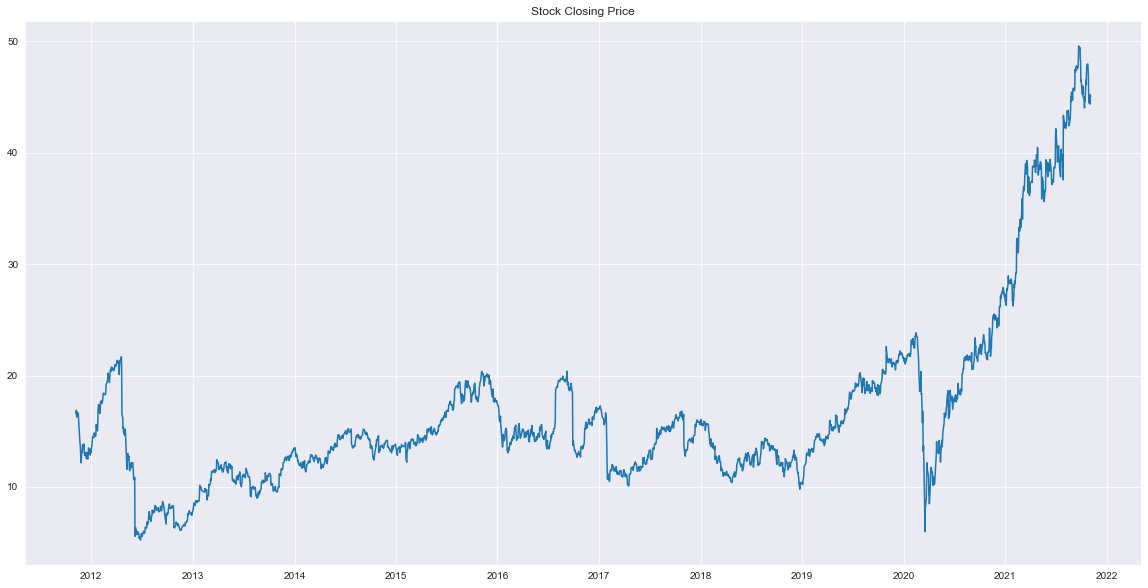

In [3]:
plt.figure(figsize=(20,10))
plt.plot(hist.Close)
plt.title('Stock Closing Price')
# plt.plot(hist.earnings)
plt.show()

## Daily stock returns are used as a proxy for historical volatility

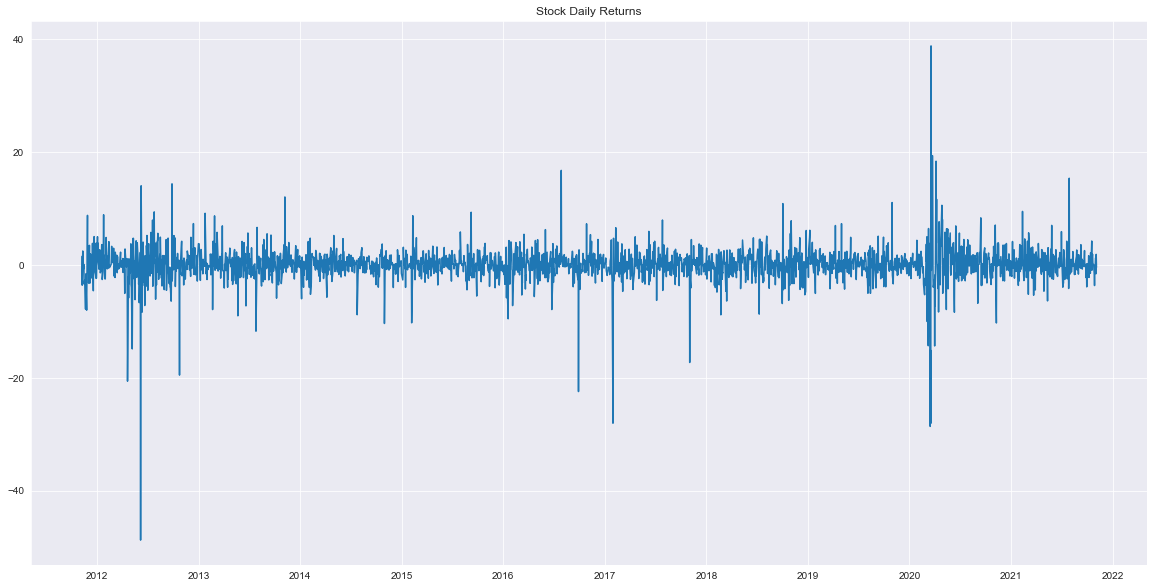

In [4]:
returns = 100 * hist.Close.pct_change().dropna()
plt.figure(figsize=(20,10))
plt.plot(returns)
# plt.plot(hist.earnings)
plt.title('Stock Daily Returns')
plt.show()

In [5]:
def autocorr_analysis(series, lags):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    sm.graphics.tsa.plot_acf(series, ax=ax1, lags=lags)
    sm.graphics.tsa.plot_pacf(series, ax=ax2, lags=lags)

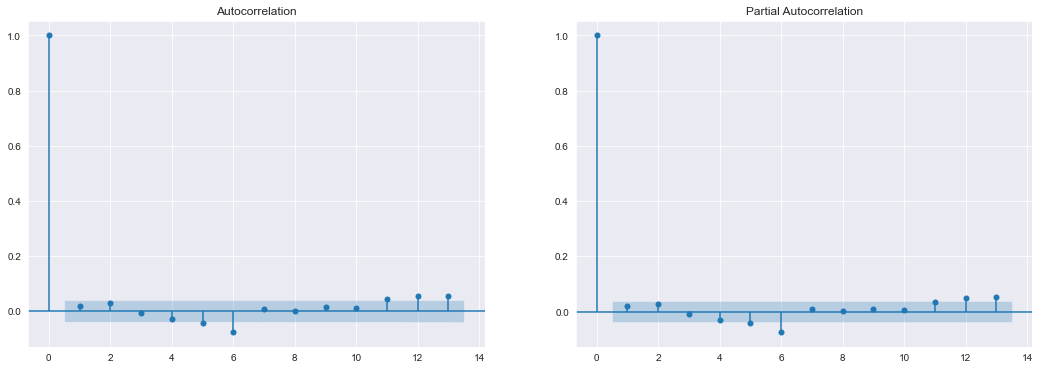

In [6]:
autocorr_analysis(returns, range(14))

### Optimal parameters and type of GARCH are selected based on the average of the AIC and BIC

In [7]:
distributions = ['normal', 'studentst', 'skewt', 'ged']
vol_models = ['GARCH', 'EGARCH', 'ARCH', 'HARCH']
means = ['constant', 'zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX']
o_list = [0,1]
# x = np.array(hist.earnings.iloc[1:])

model = None
best_score = 10000000
for dist in distributions:
    for vol in vol_models:
        for mean in means:
            for o in o_list:
                m = arch_model(returns, vol=vol, p=1, o=o, q=1, dist=dist, mean=mean)
                r = m.fit(disp='off')
                score = (r.bic + r.aic) / 2
                if score < best_score:
                    best_score = score
                    model = m

results = model.fit(disp='off')
print(results.summary())


                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5611.33
Distribution:      Standardized Student's t   AIC:                           11234.7
Method:                  Maximum Likelihood   BIC:                           11269.6
                                              No. Observations:                 2515
Date:                      Thu, Nov 04 2021   Df Residuals:                     2514
Time:                              15:13:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [8]:
def resid_analysis(residuals):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))


    mlb.rc("figure", figsize=(4,4))
    sm.graphics.tsa.plot_acf(residuals, lags=range(1,30), ax=ax1)

    ax2.scatter(range(returns.shape[0]), returns + residuals)
    ax2.plot(range(returns.shape[0]), returns, c='red')
    plt.show()

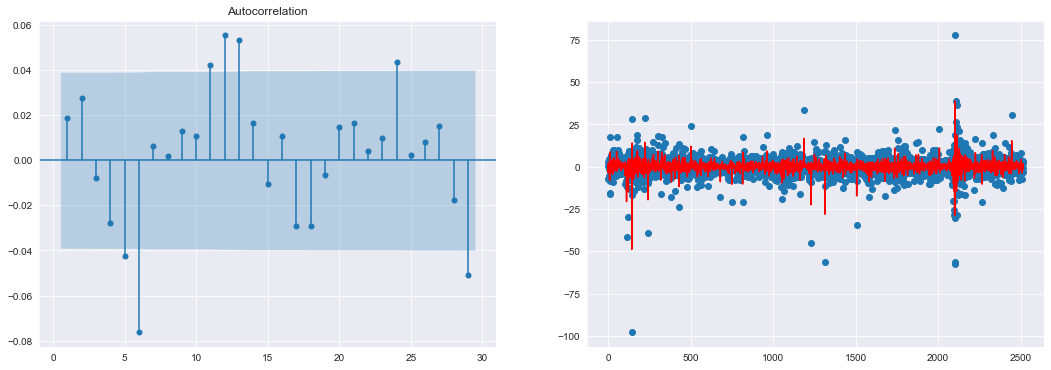

In [9]:
resid_analysis(results.resid)

### The fitted model is used to simulate possible future volatilities
### These simulations create a distribution which can be used for forecasting

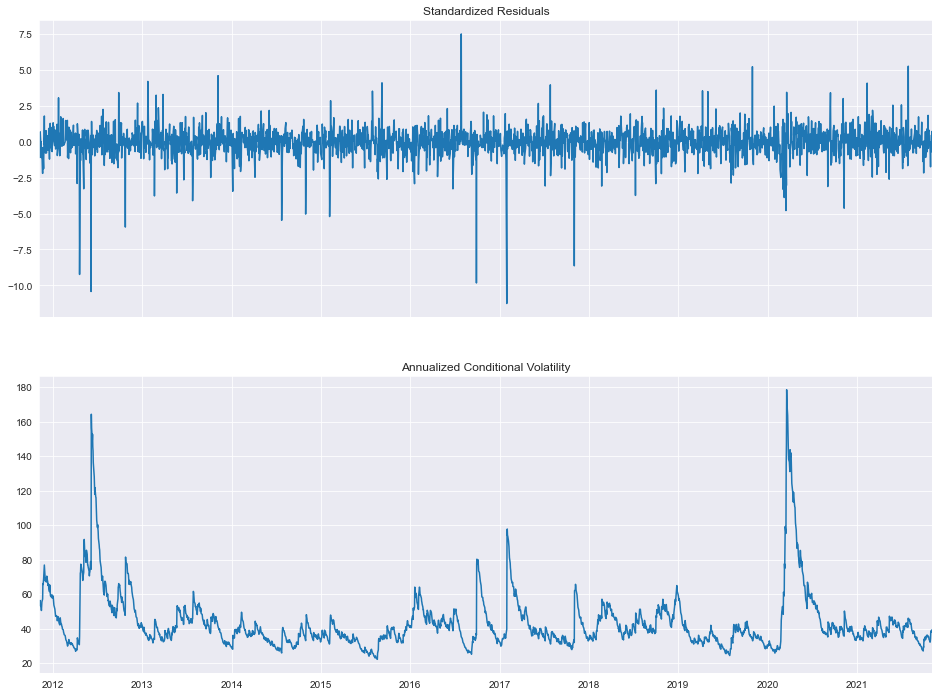

In [10]:
import warnings
warnings.filterwarnings("ignore")
fig = results.plot('D')
fig.set_size_inches(16, 12)

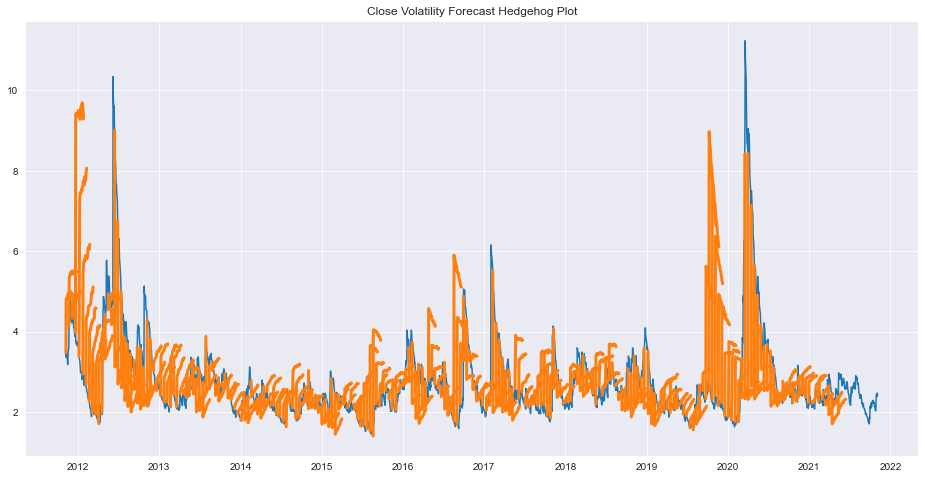

In [11]:
horizon = 23

fig = results.hedgehog_plot(method='bootstrap', horizon=horizon)
fig.set_size_inches(16, 8)


In [12]:
sim_count = 3000
forecasts = results.forecast(horizon=horizon, method='bootstrap', simulations=sim_count, reindex=True)
sims = forecasts.simulations

In [13]:
# plt.figure(figsize=(20,10))
# lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=.03)
# lines[0].set_label('Simulated paths')
# plt.show()

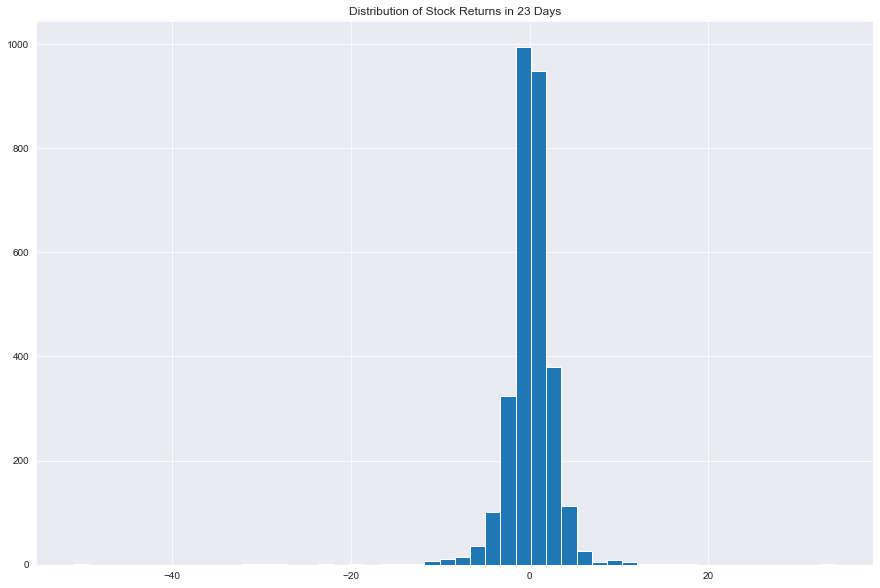

In [14]:
plt.figure(figsize=(15,10))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title(f'Distribution of Stock Returns in {horizon} Days')
plt.show()

In [15]:
sim_vals = sims.values[-1]
sim_vals = (sim_vals / 100) + 1

starting_price = np.full(shape=(sim_count,1), fill_value=hist.Close.iloc[-1])
sim_vals = np.column_stack((starting_price, sim_vals))
sim_vals = np.cumprod(sim_vals, axis=1)

end_vals = sim_vals[:, -1]

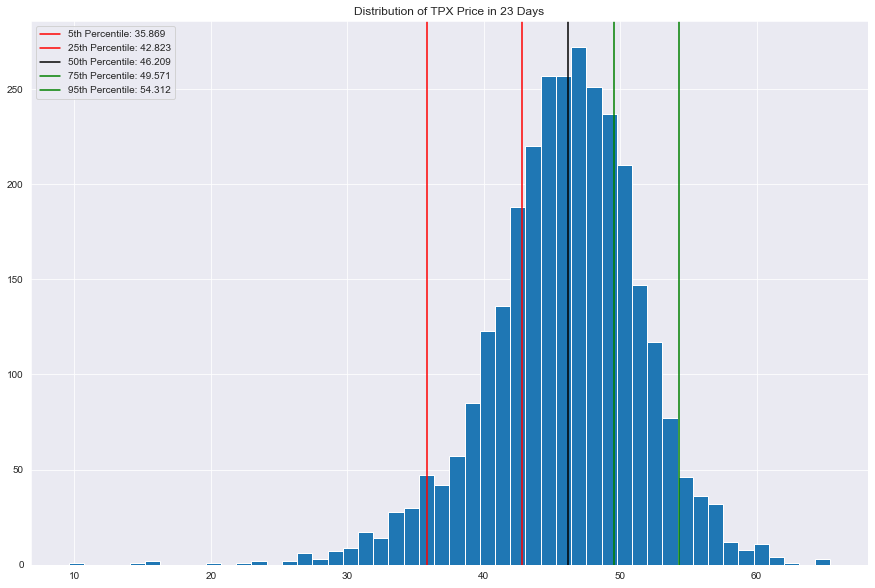

In [16]:
plt.figure(figsize=(15,10))
plt.hist(end_vals,bins=50)


def plot_percentile_prices(percentiles=[5, 25, 50, 75, 95], colors=['red', 'red', 'black', 'green', 'green'], price_chart=True):
    if len(percentiles) != len(colors):
        print("Colors and Percentiles must have the same length")
        return

    for p, c in zip(percentiles, colors):
        p_val = np.percentile(end_vals, p).round(3)
        if price_chart:
            plt.axvline(p_val, label=f'{p}th Percentile: {p_val}', color=c)
        else:
            plt.axvline(p, label=f'{p}th Percentile: {p_val}', color=c)

plot_percentile_prices()
plt.legend(loc='upper left')
plt.title(f'Distribution of {symbol} Price in {horizon} Days')
plt.show()


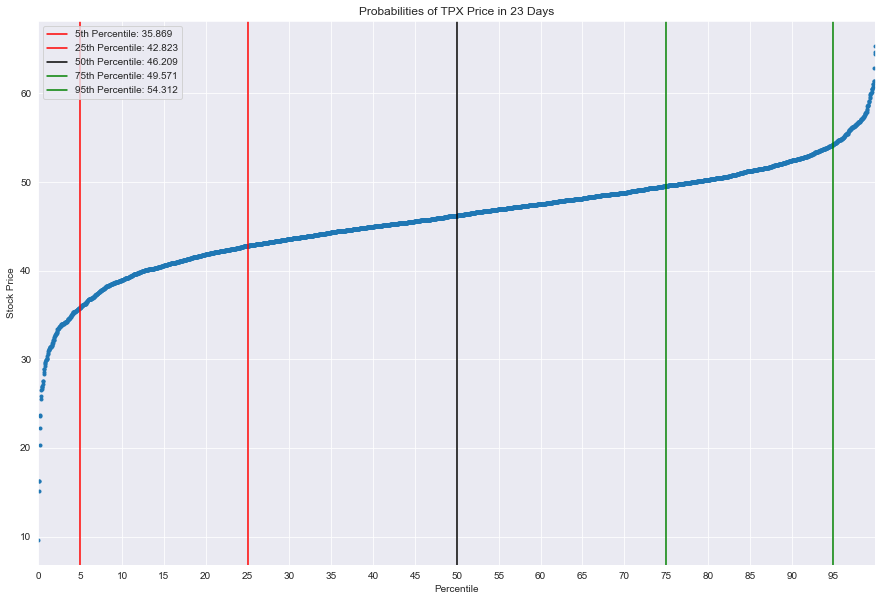

Volatility of forecasted stock price: 1.4170562612043087


In [17]:
fig, ax = plt.subplots(figsize=(15,10))
fig = probscale.probplot(end_vals, ax=ax, plottype='pp',
                         problabel='Percentile', datalabel='Stock Price',
                         scatter_kws=dict(marker='.', linestyle='none'))

plot_percentile_prices(price_chart=False)
ax.set_xticks(range(0,100,5))
plt.legend(loc='upper left')
plt.title(f'Probabilities of {symbol} Price in {horizon} Days')
plt.show()
print(
    f'Volatility of forecasted stock price: {end_vals.std() * np.sqrt(horizon/365)}')


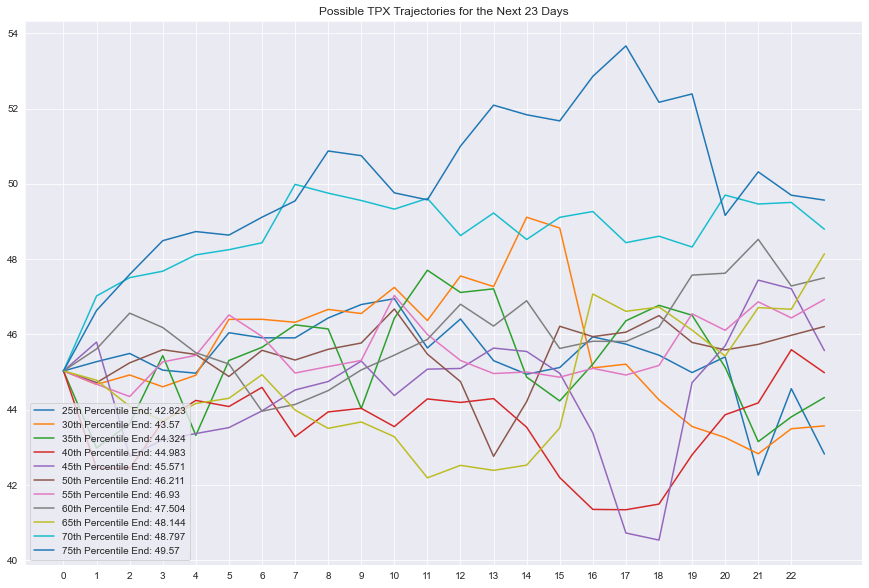

In [18]:
def plot_stock_trajectories(percentiles=[5, 25, 50, 75, 95]):
    plt.figure(figsize=(15, 10))
    plt.title(f"Possible {symbol} Trajectories for the Next {horizon} Days")
    for p in percentiles:
        percent_val = np.percentile(end_vals, p, interpolation='nearest')
        i_near = abs(end_vals - percent_val).argmin()
        plt.plot(range(horizon+1), sim_vals[i_near], label=f'{p}th Percentile End: {percent_val.round(3)}')

    if (horizon <= 25):
        plt.xticks(range(horizon))
        
    plt.legend(loc='lower left')
    plt.show()


plot_stock_trajectories([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])


In [19]:
def calc_options_expected_profit(options):
    for o in options:
        if {'type', 'strike', 'price'} > set(o):
            print("At least one of the options is missing a field.")
            return

        if o['type'] != 'call' and o['type'] != 'put':
            print("At least one of the options has a unrecognized type.")
            return

        
    expected_spread_vals = [0, 0, 0]
    expected_stock_vals = [np.percentile(end_vals, 25), np.percentile(end_vals, 50), np.percentile(end_vals, 75)]

    for o in options:
        for i, exp_stock_val in enumerate(expected_stock_vals):
            e_val = exp_stock_val - o['strike'] - o['price']
            
            if o['type'] == 'put':
                if o['price'] < 0:
                    if o['strike'] > exp_stock_val:
                        e_val = -o['price']
                else:
                    if o['strike'] > exp_stock_val:
                        e_val = o['price']

            else:
                if o['price'] < 0:
                    if o['strike'] < exp_stock_val:
                        e_val = -o['price']
                else:
                    if o['strike'] < exp_stock_val:
                        e_val = o['price']



            expected_spread_vals[i] += e_val


    return expected_spread_vals


options = [{'type': 'put', 'strike': 29, 'price': -2.2}]
print(calc_options_expected_profit(options))
options = [{'type': 'call', 'strike': 29, 'price': -2.2}]
print(calc_options_expected_profit(options))
options = [{'type': 'put', 'strike': 29, 'price': 2.2}]
print(calc_options_expected_profit(options))
options = [{'type': 'call', 'strike': 29, 'price': 2.2}]
print(calc_options_expected_profit(options))


[16.022942281417702, 19.408626093632034, 22.770682663614604]
[2.2, 2.2, 2.2]
[11.622942281417703, 15.008626093632035, 18.370682663614605]
[2.2, 2.2, 2.2]
